あ１


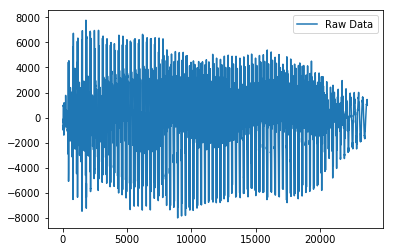

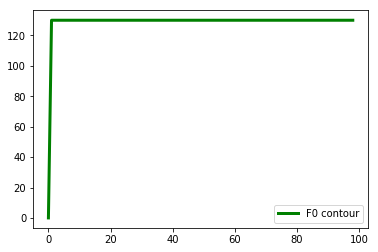

あ２


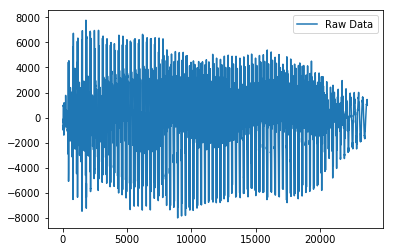

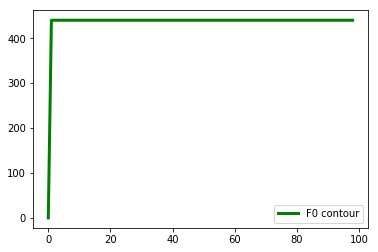

In [7]:
from scipy.io import wavfile
import pyworld as pw
import pysptk as ps
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

WAV_FILE1 = '../share/a.wav'  # １音目
WAV_FILE2 = '../share/a.wav'  # ２音目

fs1, data1 = wavfile.read(WAV_FILE1)
data1 = data1.astype(np.float)  # WORLDはfloat前提

fs2, data2 = wavfile.read(WAV_FILE2)
data2 = data2.astype(np.float)  # WORLDはfloat前提

pitch1 = 48  # C4
pitch2 = 69  # A4

def extract(data, fs):  # f0, メルケプ, bapを抽出する関数
    _f0, t = pw.dio(data, fs)  # 基本周波数の抽出
    f0 = pw.stonemask(data, _f0, t, fs)  # 基本周波数の修正
    sp = pw.cheaptrick(data, f0, t, fs)  # スペクトル包絡の抽出
    order = 60
    alpha = 0.544
    mcep = ps.conversion.sp2mc(sp, order, alpha)  # メルケプストラム
    ap = pw.d4c(data, f0, t, fs)  # 非周期性指標の抽出
    bap = np.zeros((len(t), 5))
    bap[:, 0] = np.average(ap[:, : 128])
    bap[:, 1] = np.average(ap[:, 128: 256])
    bap[:, 2] = np.average(ap[:, 256: 512])
    bap[:, 3] = np.average(ap[:, 512: 768])
    bap[:, 4] = np.average(ap[:, 768: 1025])  # bap
    return f0, mcep, bap

f01, mcep1, bap1 = extract(data1, fs1)
f02, mcep2, bap2 = extract(data2, fs2)

def makePitch(f0, pitch):#constant F0
    targetF0 = 440 * pow(2, (pitch - 69) / 12)
    newF0 = np.vectorize(lambda x: 0 if x == 0 else targetF0)(f0)
    return newF0.astype(np.double)

f01 = makePitch(f01, pitch1)
f02 = makePitch(f02, pitch2)

# 可視化
def audiomake(f0, mcep, bap, fs):  # 音を生成
    alpha = 0.544
    fftlen = 2048
    sp = ps.conversion.mc2sp(mcep, alpha, fftlen)
    ap = np.zeros((len(f0), 1025))
    for k in range(128):
        ap[:, k] = bap[:, 0]
    for k in range(128):
        ap[:, 128+k] = bap[:, 1]
    for k in range(256):
        ap[:, 256+k] = bap[:, 2]
    for k in range(256):
        ap[:, 512+k] = bap[:, 3]
    for k in range(257):
        ap[:, 768+k] = bap[:, 4]  # bap
    synthesized = pw.synthesize(f0, sp, ap, fs)
    return synthesized

syn1 = audiomake(f01, mcep1, bap1, fs1)
syn2 = audiomake(f02, mcep2, bap2, fs2)

print('あ１')
display.display(
    display.Audio(syn1, rate=fs1)
)

plt.plot(data1, label="Raw Data")
plt.legend(fontsize=10)
plt.show();

plt.plot(f01, linewidth=3, color="green", label="F0 contour")  # １音目のf0のプロット
plt.legend(fontsize=10)
plt.show();

print('あ２')
display.display(
    display.Audio(syn2, rate=fs2)
)

plt.plot(data2, label="Raw Data")
plt.legend(fontsize=10)
plt.show();

plt.plot(f02, linewidth=3, color="green", label="F0 contour")  # ２音目のf0のプロット
plt.legend(fontsize=10)
plt.show();

補間なし


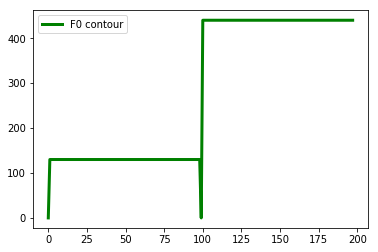

In [8]:
def connect(f01,f02,mcep1,mcep2,bap1,bap2): #補間せず接続
    f0 = np.hstack((f01,f02))
    mcep = np.vstack((mcep1,mcep2))
    bap = np.vstack((bap1,bap2))
    return f0,mcep,bap

f03, mcep3, bap3 = connect(f01,f02,mcep1,mcep2,bap1,bap2)
syn3 = audiomake(f03, mcep3, bap3, fs1)

print('補間なし')
display.display(
    display.Audio(syn3, rate=fs1)
)

plt.plot(f03, linewidth=3, color="green", label="F0 contour")  # f0のプロット
plt.legend(fontsize=10)
plt.show();

線形補間


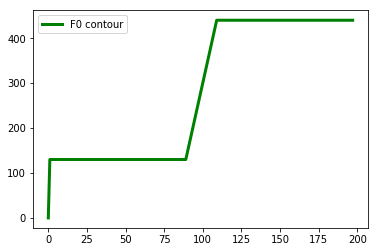

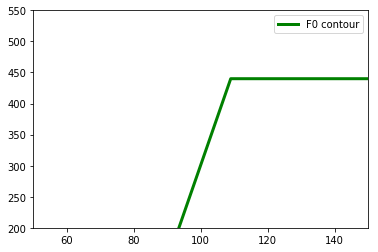

In [9]:
def hokan1(f01,f0,mcep1,mcep,bap1,bap,ran):  # 線形補間
    newf0 = modify(f01,f0,ran)
    newmcep = np.full([mcep.shape[0],mcep.shape[1]],mcep)
    newbap = np.full([bap.shape[0],bap.shape[1]],bap)
    for k in range(mcep.shape[1]):
        newmcep[:,k] = modify(mcep1[:,k],mcep[:,k],ran)
    for k in range(bap.shape[1]):
        newbap[:,k] = modify(bap1[:,k],bap[:,k],ran)
    return newf0,newmcep,newbap


def modify(data1,data,ran):
    newdata = np.array([])
    newdata = np.full([len(data),],data)
    midran = int(ran/2)
    for k in range(midran):
        newdata[len(data1)-midran+k] = fi(newdata[len(data1)-midran],newdata[len(data1)+midran],ran,k)
        newdata[len(data1)+k] = fi(newdata[len(data1)-midran],newdata[len(data1)+midran],ran,midran+k)
    return newdata

def fi(ledata,ridata,size,x):
    y = ((ridata-ledata)/size*x) + ledata
    return y

ran = 20
f04, mcep4, bap4 = hokan1(f01,f03,mcep1,mcep3,bap1,bap3,ran)
syn4 = audiomake(f04, mcep4, bap4, fs1)

print('線形補間')
display.display(
    display.Audio(syn4, rate=fs1)
)

plt.plot(f04, linewidth=3, color="green", label="F0 contour")  # f0のプロット
plt.legend(fontsize=10)
plt.show();

plt.plot(f04, linewidth=3, color="green", label="F0 contour")
plt.legend(fontsize=10)
plt.xlim(50, 150)
plt.ylim(200, 550)
plt.show();

三次関数＋線形補間


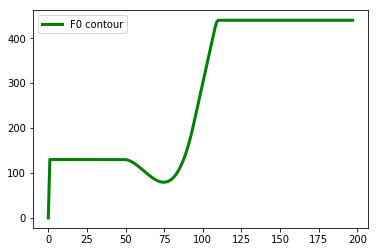

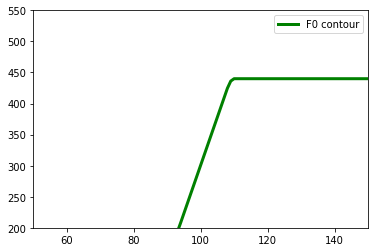

In [13]:
# 三次関数でプレパレーション，オーバーシュート・アンダーシュート

def pouconnect(f01,f03,mcep1,mcep3,bap1,bap3,p_ran1,p_ran2,p_ran3,ou_ran1,ou_ran2,ou_ran3):  # プレパレーションとオーバーシュート・アンダーシュート両方
    p_f05, mcep5, bap5 = preparation(f01,f03,mcep1,mcep3,bap1,bap3,p_ran1,p_ran2,p_ran3)
    ou_f05, _, _ = overundershoot(f01,f03,mcep1,mcep3,bap1,bap3,ou_ran1,ou_ran2,ou_ran3)
    f05 = np.concatenate((p_f05[: len(f01)],ou_f05[len(f01): len(ou_f05)]))
    return  f05, mcep5, bap5

def preparation(f01,f03,mcep1,mcep3,bap1,bap3,ran1,ran2,ran3):  # プレパレーション
    l = (f03[len(f01) + ran2] - f03[len(f01) - ran2]) / (ran2 * 2)
    x1 = len(f01) - ran3
    y1 = f03[len(f01) - ran3]
    x2 = len(f01) - ran1
    y2 = f03[len(f01) - ran2] + l * (ran2 - ran1)
    C1 = matrix(x1,y1,x2,y2,l)
    f05, mcep5, bap5 = hokan1(f01,f03,mcep1,mcep3,bap1,bap3,ran2*2)
    for k in range(ran3 - ran1):
        t1 = len(f01)-ran3+k
        f05[t1] = C1[0,0]*(t1)**3 + C1[1,0]*(t1)**2 + C1[2,0]*t1 + C1[3,0]
    return f05, mcep5, bap5

def overundershoot(f01,f03,mcep1,mcep3,bap1,bap3,ran1,ran2,ran3):  # オーバーシュート・アンダーシュート
    l = (f03[len(f01) + ran2] - f03[len(f01) - ran2]) / (ran2 * 2)
    x1 = len(f01) + ran3
    y1 = f03[len(f01) + ran3]
    x2 = len(f01) + ran1
    y2 = f03[len(f01) + ran2] - l * (ran2 - ran1)
    C2 = matrix(x1,y1,x2,y2,l)
    f05, mcep5, bap5 = hokan1(f01,f03,mcep1,mcep3,bap1,bap3,ran2*2)
    for k in range(ran3 - ran1):
        t2 = len(f01)+ran3-k
        f05[t2] = C2[0,0]*(t2)**3 + C2[1,0]*(t2)**2 + C2[2,0]*t2 + C2[3,0]
    return f05, mcep5, bap5

def matrix(x1,y1,x2,y2,l):  # 三次関数の導出
    A = np.array([[x1**3,x1**2,x1,1],[x2**3,x2**2,x2,1],[3*x1**2,2*x1,1,0],[3*x2**2,2*x2,1,0]])
    B = np.array([[y1],[y2],[0],[l]])
    inv_A = np.linalg.inv(A)
    C = np.dot(inv_A, B)
    return C

# 条件 ran3 > ran2 > ran1

p_ran1 = 5
p_ran2 = 10
p_ran3 = 35

ou_ran1 = 5
ou_ran2 = 10
ou_ran3 = 35

f05, mcep5, bap5 = pouconnect(f01,f03,mcep1,mcep3,bap1,bap3,p_ran1,p_ran2,p_ran3,ou_ran1,ou_ran2,ou_ran3)

_, mcep5, _ = hokan1(f01,f03,mcep1,mcep3,bap1,bap3,20)

syn5 = audiomake(f05, mcep5, bap5, fs1)

print('三次関数＋線形補間')
display.display(
    display.Audio(syn5, rate=fs1)
)

plt.plot(f05, linewidth=3, color="green", label="F0 contour")  # f0のプロット
plt.legend(fontsize=10)
plt.show();

plt.plot(f05, linewidth=3, color="green", label="F0 contour")
plt.legend(fontsize=10)
plt.xlim(50, 150)
plt.ylim(200, 550)
plt.show();